# Libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

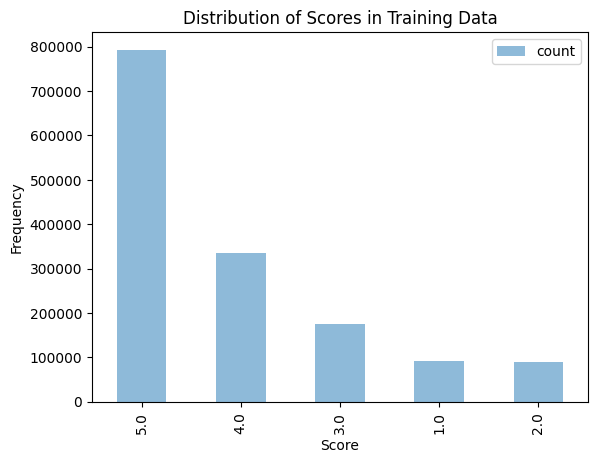


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START



In [57]:
# Load the data
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

# Check the shape of both datasets
print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Plot the distribution of 'Score'
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Distribution of Scores in Training Data")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

print("\nEVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START\n")

In [18]:
print(trainingSet.columns)
print(testingSet.columns)


Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')
Index(['Id', 'Score'], dtype='object')


# Adding Features

In [58]:
def add_features(df, is_training=True):
    if is_training:
        # Check if 'HelpfulnessNumerator' and 'HelpfulnessDenominator' exist
        if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
            # Handle missing values in 'HelpfulnessNumerator' and 'HelpfulnessDenominator'
            df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].fillna(0)
            df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].fillna(1)  # To avoid division by zero

            # Create HelpfulnessRatio
            df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

            # Drop unnecessary columns
            df = df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'])
        
        # Handle missing values in the 'Text' column by replacing NaN with empty strings
        df['Text'] = df['Text'].fillna('')

        # Create ReviewWordCount and ReviewCharCount
        df['ReviewWordCount'] = df['Text'].apply(lambda x: len(x.split()))  # Word count
        df['ReviewCharCount'] = df['Text'].apply(lambda x: len(x))  # Character count

        # Handle Time column (convert Unix timestamp to datetime, extract year and month)
        df['Time'] = pd.to_datetime(df['Time'], unit='s')
        df['Year'] = df['Time'].dt.year
        df['Month'] = df['Time'].dt.month

        # Create a 'Season' feature
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        df['Season'] = df['Month'].apply(get_season)
    
    # Return the modified DataFrame
    return df

In [61]:
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
import pandas as pd

def process_data(df, reference_date=pd.to_datetime("today")):
    # Metadata features to include
    numeric_metadata_features = ['HelpfulnessRatio', 'ReviewWordCount', 'ReviewCharCount']

    # 1. Sentiment Analysis Features
    def get_sentiment(text):
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity

    df[['Polarity', 'Subjectivity']] = df['Text'].apply(lambda x: pd.Series(get_sentiment(x)))

    # 2. Length of Review Features
    df['AvgWordLength'] = df['ReviewCharCount'] / df['ReviewWordCount']
    df['UniqueWordCount'] = df['Text'].apply(lambda x: len(set(x.split())))
    df['UniqueWordRatio'] = df['UniqueWordCount'] / df['ReviewWordCount']

    # 3. Helpfulness Ratio Features
    df['IsHelpful'] = df['HelpfulnessRatio'].apply(lambda x: 1 if x >= 0.5 else 0)

    # 4. Temporal Features
    df['Hour'] = df['Time'].dt.hour
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df['DaysSinceReview'] = (reference_date - df['Time']).dt.days

    # 5. Product Features
    product_avg_rating = df.groupby('ProductId')['Score'].transform('mean')
    df['ProductAvgRating'] = product_avg_rating

    product_review_count = df.groupby('ProductId')['Score'].transform('count')
    df['ProductReviewCount'] = product_review_count

    # 6. Reviewer Features
    reviewer_avg_rating = df.groupby('UserId')['Score'].transform('mean')
    df['ReviewerAvgRating'] = reviewer_avg_rating

    reviewer_review_count = df.groupby('UserId')['Score'].transform('count')
    df['ReviewerReviewCount'] = reviewer_review_count

    # 7. Normalize Numeric Metadata Features
    numeric_features = numeric_metadata_features + ['AvgWordLength', 'UniqueWordRatio', 'Polarity', 'Subjectivity',
                                                    'ProductAvgRating', 'ProductReviewCount', 'ReviewerAvgRating',
                                                    'ReviewerReviewCount', 'DaysSinceReview']
    
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features].fillna(0))  # Handling NaNs

    # 8. One-Hot Encode 'Season' Feature
    season_encoded = pd.get_dummies(df['Season'], prefix='Season')
    df = pd.concat([df, season_encoded], axis=1)

    # Drop unused columns
    df = df.drop(['Text', 'Time', 'Season'], axis=1, errors='ignore')
    
    return df

# Example usage:
# processed_trainingSet = process_data(sampled_trainingSet)
# processed_testingSet = process_data(testingSet)

ModuleNotFoundError: No module named 'textblob'

# Data Processing

In [59]:

# Step 1: Randomly sample 20% of the dataset
sampled_trainingSet = trainingSet.sample(frac=0.20, random_state=42)

# Step 2: Process the sampled training set
sampled_trainingSet = add_features(sampled_trainingSet, is_training=True)

# Step 3: Drop the 'Summary' column since we're analyzing the full 'Text' column
sampled_trainingSet = sampled_trainingSet.drop(columns=['Summary'])

print("Sampled and processed data shape:", sampled_trainingSet.shape)

Sampled and processed data shape: (339507, 12)


# Data Processing

TF-IDF Vectorization

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Create TF-IDF vectorizer and fit it on the entire dataset
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, max_df=0.7)

# Fit the vectorizer on the 'Text' column to capture the vocabulary and transform the text
tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_trainingSet['Text'])

print("TF-IDF vectorizer fitting completed!")

# Apply Truncated SVD to reduce the dimensionality of the TF-IDF matrix
n_components = 100  # You can adjust this number as needed
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit and transform the TF-IDF matrix with Truncated SVD
tfidf_reduced = svd.fit_transform(tfidf_matrix)

print(f"Dimensionality reduced to {n_components} components using Truncated SVD.")

TF-IDF vectorizer fitting completed!
Dimensionality reduced to 100 components using Truncated SVD.


Train-test-split

In [39]:
print(sampled_trainingSet.columns)

Index(['Id', 'ProductId', 'UserId', 'Time', 'Text', 'Score',
       'HelpfulnessRatio', 'ReviewWordCount', 'ReviewCharCount', 'Year',
       'Month', 'Season'],
      dtype='object')


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Metadata features to include (excluding 'Season' for one-hot encoding)
numeric_metadata_features = ['HelpfulnessRatio', 'ReviewWordCount', 'ReviewCharCount']

# One-hot encode the 'Season' column and convert it into 0/1 values
season_encoded = pd.get_dummies(sampled_trainingSet['Season'], prefix='Season')

# Normalize the numeric metadata features
scaler = StandardScaler()
normalized_numeric_metadata = scaler.fit_transform(sampled_trainingSet[numeric_metadata_features])
normalized_numeric_metadata_df = pd.DataFrame(normalized_numeric_metadata, columns=numeric_metadata_features)

# Combine normalized numeric metadata with one-hot encoded 'Season'
X_metadata = pd.concat([normalized_numeric_metadata_df.reset_index(drop=True), season_encoded.reset_index(drop=True)], axis=1)

# Ensure tfidf_reduced has appropriate column names if it's an array
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=[f"TFIDF_{i}" for i in range(tfidf_reduced.shape[1])])

# Combine the reduced TF-IDF matrix with metadata features
X_combined = pd.concat([tfidf_reduced_df.reset_index(drop=True), X_metadata.reset_index(drop=True)], axis=1)

# Define the target variable
y = sampled_trainingSet['Score'].fillna(sampled_trainingSet['Score'].median())  # Handle missing values in target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

print("Train-test split completed!")

Train-test split completed!


# Feature Selection

In [42]:
# Assuming 'testingSet' is your submission dataset:
X_submission = testingSet

# If you need to process X_submission (like with 'process_data' function):
X_submission = process_data(X_submission, is_training=False)


# Model Creation

Tune hyperparameters

In [43]:
import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Predict the scores on the test data
y_test_pred = xgb_model.predict(X_test)

print("XGBoost Model Training and Prediction Completed!")

XGBoost Model Training and Prediction Completed!


In [51]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
}

random_search = RandomizedSearchCV(xgb_model, param_distributions, n_iter=20, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [52]:
y_test_pred = best_xgb_model.predict(X_test)

# Model Evaluation

Accuracy on testing set = 0.47434522897840403


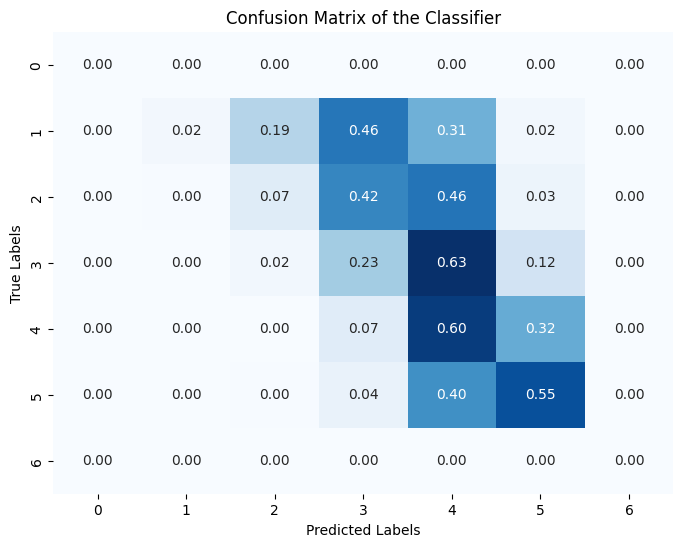

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert continuous predictions to nearest integer classes
y_test_pred_class = np.rint(y_test_pred).astype(int)

# Evaluate accuracy on the testing set
accuracy = accuracy_score(y_test, y_test_pred_class)
print("Accuracy on testing set =", accuracy)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_class, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create submission file

In [27]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

NameError: name 'model' is not defined